# Load datasets and build one dataset by language

**Datasets:**
1. New round-2 completions (what we have labelled)
2. Old round-1 completions (what we have labelled)
3. Collected from telegram channels (we've collected channels for topics and downloaded posts)
4. Telegram provided labels from r-1 (true labels from round-1 for en and ru)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
import logging
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from torchtext import data
import re
# custom path
os.chdir('../..')


In [2]:
from src.train.predict import load_test_file

## Data prep

In [3]:
COMPLETIONS_R2 = [
    'data/raw/r-2/completions/project-1-at-2021-04-20-16-16-72cac916.json',
    'data/raw/r-2/completions/project-1-at-2021-05-02-05-39-0691dc6b.json',
]

COMPLETIONS_R1 = [
    'data/raw/r-1/completions/2020-02-14_completions.json',
    'data/raw/r-1/completions/2020-02-14_active_completions.json',
]

TG_DOWNLOADS = {
        'META': 'data/raw/r-2/downloads/meta.csv',
        'POSTS': 'data/raw/r-2/downloads/posts.csv',
        'TOPICS': 'data/external/telegram_channels.csv'
    }

TG_TRUE_LABELS = [
    {
        'lang_code': 'en',
        'input': 'data/external/r-1/submission1489/category_en/input.txt',
        'output': 'data/external/r-1/submission1489/category_en/tg_output.txt'
    },
    {
        'lang_code': 'ru',
        'input': 'data/external/r-1/submission1489/category_ru/input.txt',
        'output': 'data/external/r-1/submission1489/category_ru/tg_output.txt'
    },
]

PRIMARY2SECONDARY = 3

In [4]:
def calc_topic_weights(primary, secondary):
    """ create a weight dict from topics """
    total = len(primary) * PRIMARY2SECONDARY + len(secondary)
    weights = {p: PRIMARY2SECONDARY / total for p in primary}
    weights.update({s: 1 / total for s in secondary})
    return weights


def get_topics(value):
    """ return a list of topics from one string topic or multiple from a dict """
    if isinstance(value, dict):
        topics = value['choices']
    else:
        topics = [value] if value != '' else []
    return topics


def raise_non_existent(file):
    raise Exception(f'{file} does not exist')


def load_labelled_data(files):
    if len(files) == 0:
        return pd.DataFrame()
    for f in files:
        if not os.path.exists(f):
            raise_non_existent(f)
    labelled_data = [pd.read_json(c,) for c in files]
    labelled_data = pd.concat(labelled_data)
    labelled_data['secondary'].fillna('', inplace=True)
    labelled_data['primary'] = labelled_data['primary'].apply(get_topics)
    labelled_data['secondary'] = labelled_data['secondary'].apply(get_topics)
    labelled_data['category'] = labelled_data.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), axis=1)
    labelled_data.drop([
        'primary','secondary', # encoded into `category`
        'subscribers', 'counters', # for now
        'annotator', 'annotation_id', 'title_display', 'description_display', 'recent_posts_display', # from new completions
        "predictions", "score", "posts", # old completions
    ], axis=1, inplace=True, errors='ignore')
    labelled_data.info()
    return labelled_data


def prepare_text(row):
    """ extract and merge all text from a channel """
    post_texts = '\n'.join([
        post.get('text', "") 
        if isinstance(post, dict) else post
        for post in row['recent_posts']
    ])
    merged = '\n'.join([row['title'], row['description'], post_texts])
    return merged


def show_lang_stats(data):
    lang_counts = data['lang_code'].value_counts()
    c = Counter()
    _ = [c.update(cat) for cat in data['category']]
    c = pd.DataFrame(c.most_common(len(c)), columns=['topic','score'])
    fig,axes = plt.subplots(1, 2, figsize=(15,7))
    sns.barplot(x=lang_counts, y=lang_counts.index, ax=axes[1]);
    sns.barplot(x=c['score'],y=c['topic'], ax=axes[0] );

### Load

#### New completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 789
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         800 non-null    object
 1   description   800 non-null    object
 2   recent_posts  800 non-null    object
 3   lang_code     800 non-null    object
 4   id            800 non-null    int64 
 5   category      800 non-null    object
dtypes: int64(1), object(5)
memory usage: 43.8+ KB


,title,description,recent_posts,lang_code,id,category,subset
57,👑 REAL MADRID 🇪🇸,🇪🇸 Real Madrid 🇺🇿 klubining O'zbekistondagi en...,"[{'type': 'photo', 'text': 'Sky Sports: David ...",uz,888,{'Sports': 1.0},r-2
586,ﺷﹻﹻﹻ۬ﹻۛ۬ﹻ۬ﹻﹻﹻۋڴ𝄞,أنا الككارثةہ ألتيہ سہ تسير متلهففاً للوقوعہ ب...,"[{'type': 'photo', 'text': '🥺🍗'}, {'type': 'te...",ar,232,"{'Religion & Spirituality': 0.75, 'Art & Desig...",r-2
121,الكاتبة والمصممة؛صمت الكلمات👒🌂,مريم ابراهيم (ام حور ) كاتبة، تكتب خواطر ومقال...,"[{'type': 'text', 'text': '(في رحاب رمضان) {ق...",ar,802,"{'Religion & Spirituality': 0.6, 'Celebrities ...",r-2
340,Красивая сервировка 🍽,Идеи для модной сервировки стола на каждый ден...,"[{'type': 'photo', 'text': 'Yaqinlaringizga ha...",uz,511,"{'Food & Cooking': 0.75, 'Home & Architecture'...",r-2


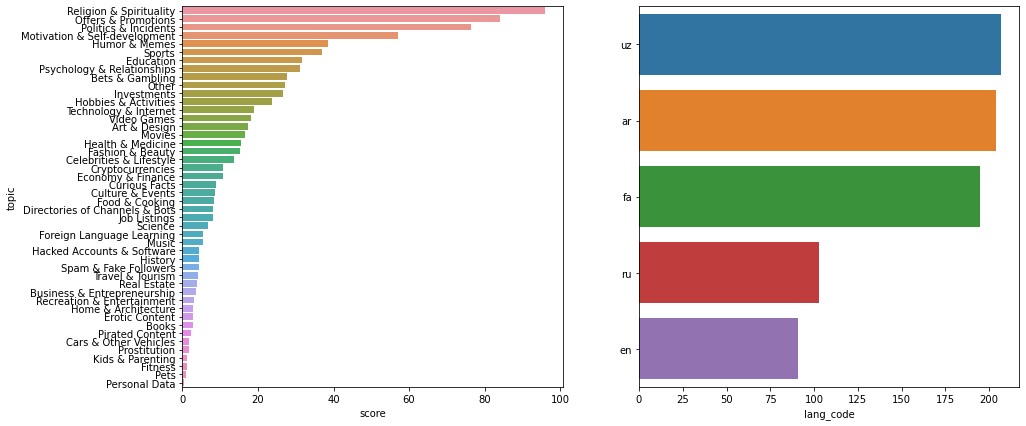

In [5]:
new_labels = load_labelled_data(COMPLETIONS_R2)
new_labels['subset'] = 'r-2'

show_lang_stats(new_labels)

new_labels.sample(4)


#### Old completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 282
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   691 non-null    object
 1   lang_code     691 non-null    object
 2   recent_posts  691 non-null    object
 3   title         691 non-null    object
 4   id            691 non-null    int64 
 5   category      691 non-null    object
dtypes: int64(1), object(5)
memory usage: 37.8+ KB


,description,lang_code,recent_posts,title,id,category,subset
191,"Не Украина и не Русь, боюсь, Донбасс, тебя, бо...",ru,[Программа импортозамещения в ДНР\n\nСудя по в...,Донбасский Кейс,336,{'Politics & Incidents': 1.0},r-1
165,🚀8000+ monthly pips 🚀\nWELCOME TO THE FOREX RE...,en,[I am giving 0.005 btc to first 20 members who...,🚀ROCKET SIGNALS FX🚀,258,{'Investments': 1.0},r-1
383,,ru,[​Circle представила новый API для перевода US...,Трейдинг | Trading | Bitcoin-новости,7,"{'Cryptocurrencies': 0.5, 'Investments': 0.5}",r-1


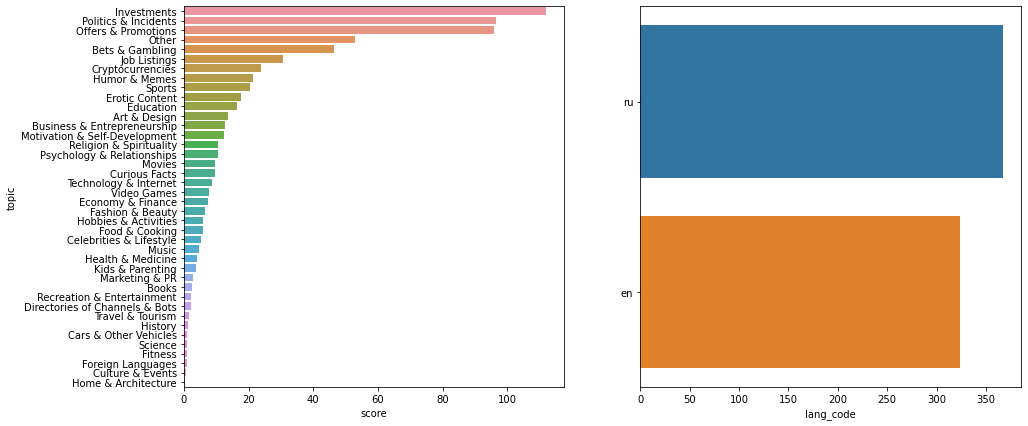

In [6]:
old_labels = load_labelled_data(COMPLETIONS_R1)
old_labels['subset'] = 'r-1'


show_lang_stats(old_labels)

old_labels.sample(3)


#### Tg channel downloads

In [7]:
posts = pd.read_csv(TG_DOWNLOADS['POSTS'])
meta = pd.read_csv(TG_DOWNLOADS['META'])
topics = pd.read_csv(TG_DOWNLOADS['TOPICS'])

# clean
topics['topic [Secondary]'].fillna("", inplace=True)
posts['message'].fillna("", inplace=True)
meta['about'].fillna("", inplace=True)

# new cols
topics['username'] = topics['link'].apply(lambda x: x.split('/')[-1])
topics['lang_code'] = topics['language'].apply(lambda x: x.lower()[:2])

# rename
posts.rename({'channel':'username', 'message': 'recent_posts'}, axis=1, inplace=True)
meta.rename({'about':'description',}, axis=1, inplace=True)

# calculate topic weights
topics['primary'] = topics['topic [Primary]'].apply(lambda x: x.split(','))
topics['secondary'] = topics['topic [Secondary]'].apply(lambda x: x.split(',') if x != '' else [])
topics['category'] = topics.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), 
                               axis=1)

# group recent posts
posts = posts.groupby('username', as_index=False).agg({'recent_posts': lambda row: list(x for x in row if x != '')})


# merge
tg_downloads = topics[['username','lang_code','category']]\
            .merge(meta, on=['username'])\
            .merge(posts, on='username')
tg_downloads['subset'] = 'chan'


del tg_downloads['username']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 243
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lang_code     244 non-null    object
 1   category      244 non-null    object
 2   title         244 non-null    object
 3   description   244 non-null    object
 4   recent_posts  244 non-null    object
 5   subset        244 non-null    object
dtypes: object(6)
memory usage: 13.3+ KB


,lang_code,category,title,description,recent_posts,subset
194,en,{'Kids & Parenting': 1.0},Baby Parenting 👶🏻,"Best Baby product Review, Best Advice for moms...",[Baby Parenting would love your feedback. Post...,chan
62,ru,"{'Movies': 0.5, ' Pirated Content': 0.5}",Кинобар БлокБастер,,[Темная Башня / 2017\n\n✸ режиссер Николай Ар...,chan
61,ru,{'Prostitution': 1.0},блокбастеры порно,Знакомства,[Ты знал что много девушек в твоём городе ищут...,chan
172,ru,"{'Drug Sale': 0.42857142857142855, ' Hobbies &...",Выращивание марихуаны конопли МАРИХУАНА,Все о марихуане и конопле. Как купить семена ...,[Когда дело доходит до выращивания на открытом...,chan


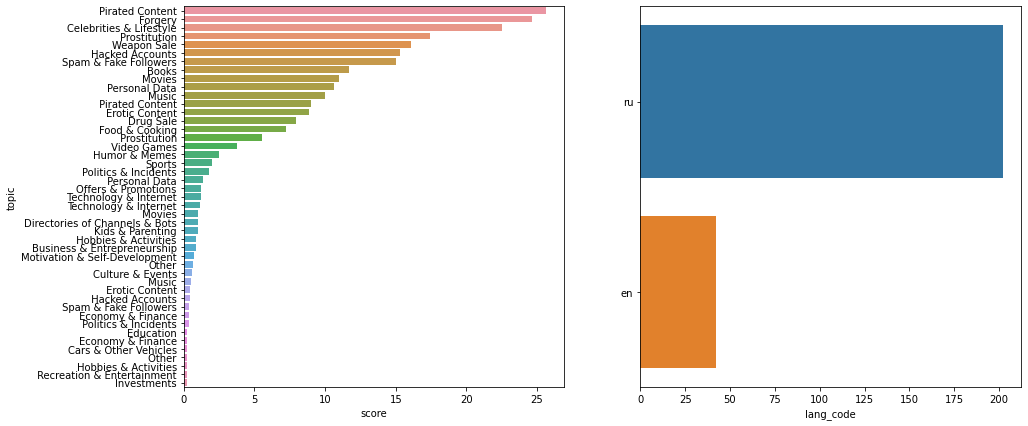

In [8]:
tg_downloads.info()

show_lang_stats(tg_downloads)

tg_downloads.sample(4)


#### Tg true labels

In [9]:
def update_dict(src_dict,dest_dict):
    src_dict.update(dest_dict)
    return src_dict

In [10]:
tg_true = []

for files in TG_TRUE_LABELS:
    inp = load_test_file(files['input'])
    out = load_test_file(files['output'])
    tg_true.extend([update_dict(i, o) for i,o in zip(inp, out)])

    
tg_true = pd.DataFrame(tg_true)

tg_true['subset'] = 'tg'

Loaded 14775 rows
Loaded 14775 rows
Loaded 16726 rows
Loaded 16726 rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31501 entries, 0 to 31500
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         31501 non-null  object
 1   description   31501 non-null  object
 2   recent_posts  31501 non-null  object
 3   lang_code     31501 non-null  object
 4   category      31501 non-null  object
 5   subset        31501 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


,title,description,recent_posts,lang_code,category,subset
25649,Это же твои обещания?,Это же твои обещания стать лучше?,"[​​​​Myжчинa и жeнщинa, yмeющиe cepьeзнo и чec...",ru,{'Recreation & Entertainment': 0.1428571428571...,tg
15880,Запуск TikTok | Блог Александра Турлакова,📝TikTok марафон и сотрудничество\n@TurlaTikTok...,[TikTok хаус | открытый event в Санкт-Петербур...,ru,"{'Marketing & PR': 0.14285714285714, 'Technolo...",tg
28173,Железобетонный замес,Закрытый мир недвижимости и политики.\nРедакци...,[Регионы должны стремиться к увязке программ п...,ru,"{'Politics & Incidents': 0.85714285714286, 'Re...",tg


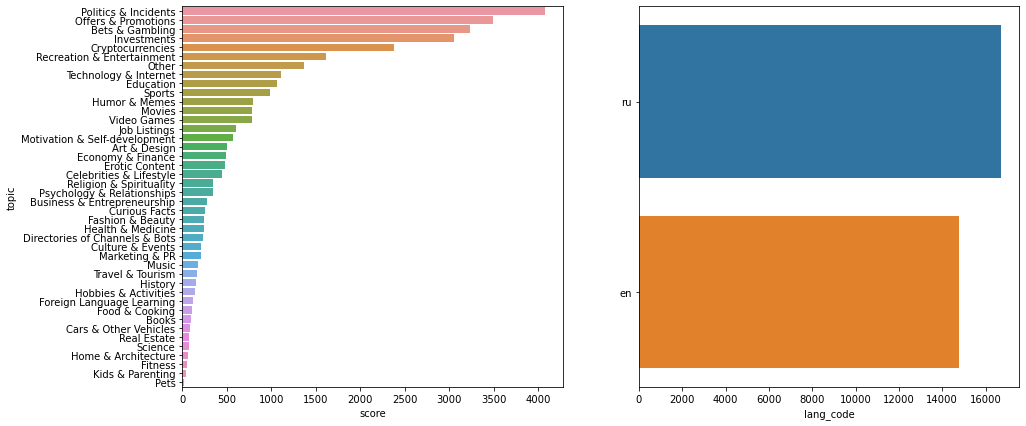

In [11]:
tg_true.info()

show_lang_stats(tg_true)

tg_true.sample(3)

## Combine and save

### concat

In [12]:
comb = pd.concat([
    new_labels,
    old_labels,
    tg_downloads,
    tg_true,

], axis=0)
comb.shape

(33236, 7)

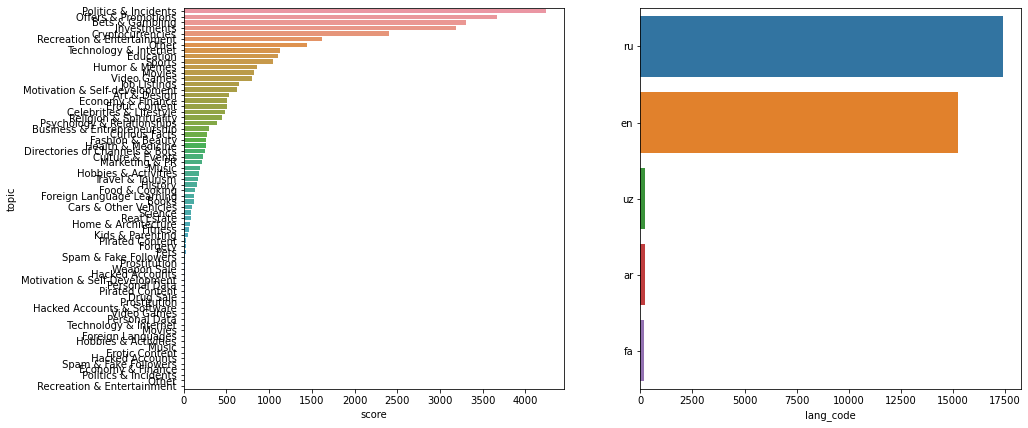

In [13]:
show_lang_stats(comb)

In [14]:
comb['subset'].value_counts()

tg      31501
r-2       800
r-1       691
chan      244
Name: subset, dtype: int64

### get raw texts

In [15]:
comb['text'] = comb.apply(prepare_text, axis=1)

### Save

In [16]:
comb.to_csv('data/interim/train_data.csv', index=False)